In [43]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [44]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS =3
EPOCHS = 10
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

In [45]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [46]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

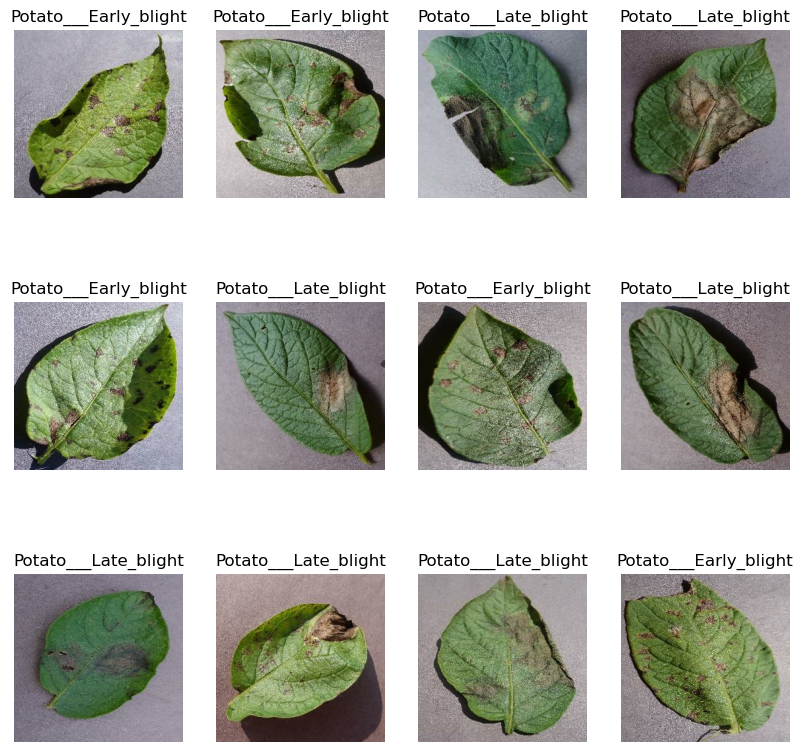

In [47]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,1+i)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [48]:
def get_dataset_partitions_tf(ds, train_split=0.75, val_split=0.125, test_split=0.125, shuffle=True, shuffle_size=10000):
  assert  (train_split + test_split + val_split) == 1

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  val_size = int(val_split * ds_size)
    
  train_ds = ds.take(train_size)    
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
    
  return train_ds, val_ds, test_ds

In [49]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

51
8
9


In [50]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

In [51]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [52]:
data_augmentation = tf.keras.Sequential([
 layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
 layers.experimental.preprocessing.RandomRotation(0.2),
])

In [53]:
nput_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [54]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/10
51/51 [==============================] - 63s 1s/step - loss: 0.7170 - accuracy: 0.7053 - val_loss: 0.3988 - val_accuracy: 0.8516
Epoch 2/10
51/51 [==============================] - 60s 1s/step - loss: 0.3804 - accuracy: 0.8652 - val_loss: 0.2741 - val_accuracy: 0.8828
Epoch 3/10
51/51 [==============================] - 61s 1s/step - loss: 0.1982 - accuracy: 0.9308 - val_loss: 0.2419 - val_accuracy: 0.9062
Epoch 4/10
51/51 [==============================] - 61s 1s/step - loss: 0.1793 - accuracy: 0.9320 - val_loss: 0.0879 - val_accuracy: 0.9688
Epoch 5/10
51/51 [==============================] - 61s 1s/step - loss: 0.1022 - accuracy: 0.9663 - val_loss: 0.1032 - val_accuracy: 0.9570
Epoch 6/10
51/51 [==============================] - 61s 1s/step - loss: 0.1073 - accuracy: 0.9559 - val_loss: 0.1090 - val_accuracy: 0.9648
Epoch 7/10
51/51 [==============================] - 60s 1s/step - loss: 0.0498 - accuracy: 0.9841 - val_loss: 0.0887 - val_accuracy: 0.9688
Epoch 8/10
51/51 [==

In [55]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

9/9 [==============================] - 3s 251ms/step - loss: 0.0255 - accuracy: 0.9896
Test Loss: 0.025521360337734222
Test Accuracy: 0.9895833134651184


In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

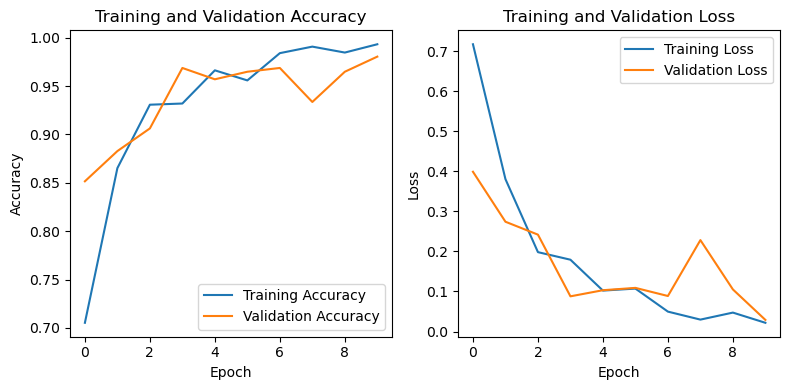

In [57]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


In [58]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 38ms/step


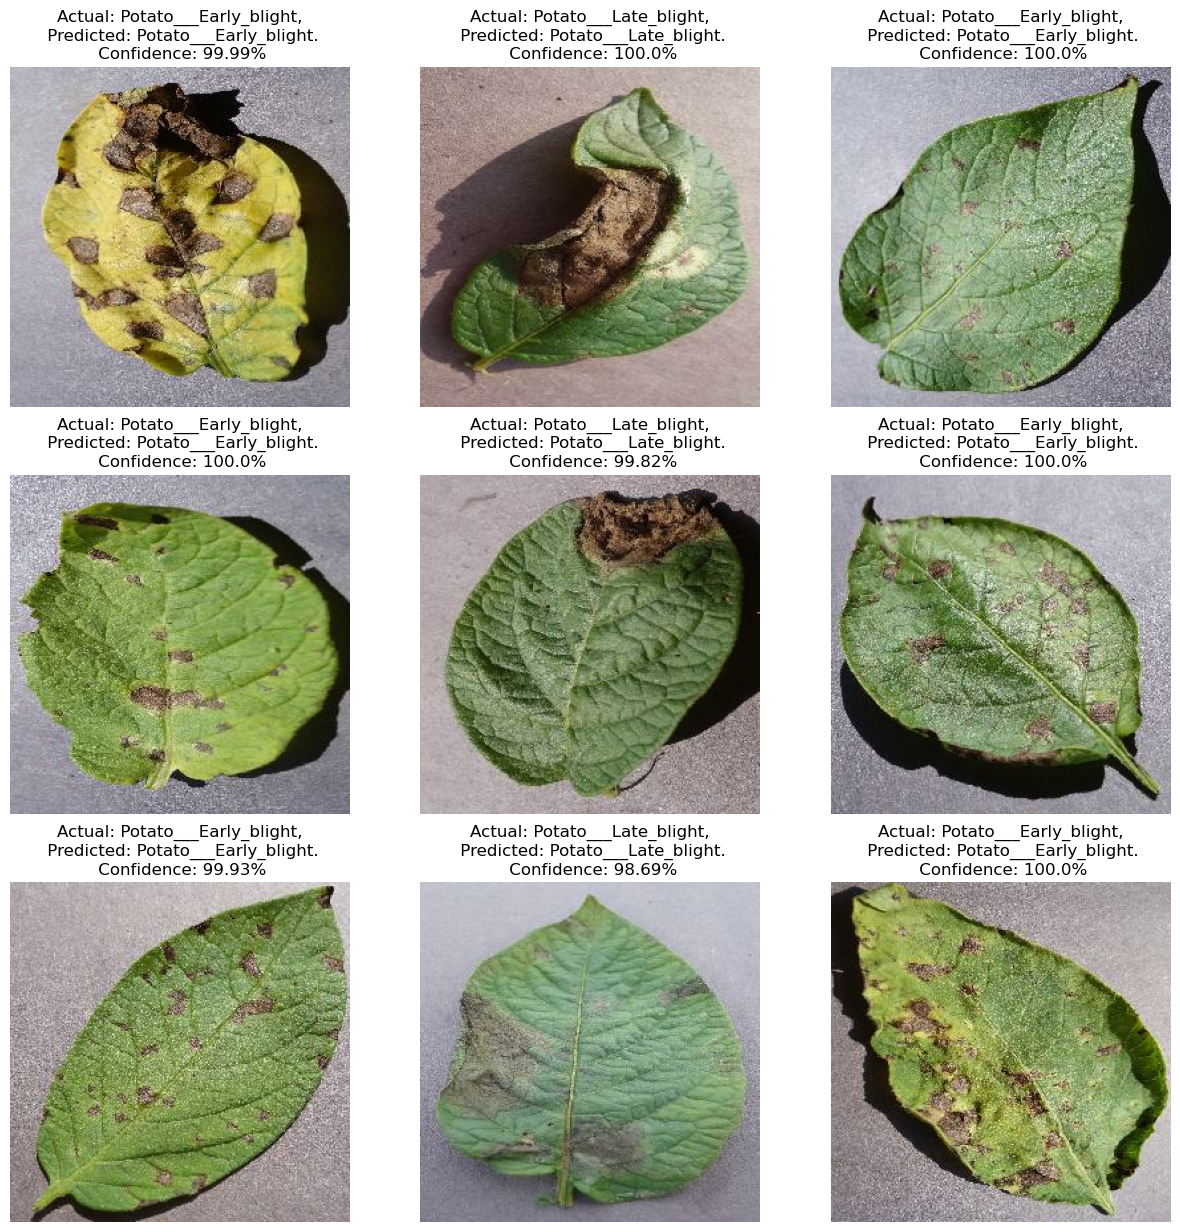

In [59]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [61]:
# Make predictions on the test set
y_true = []
y_pred = []
for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels)
    y_pred.extend(np.argmax(predictions, axis=1))

1/1 [==============================] - 0s 353ms/step


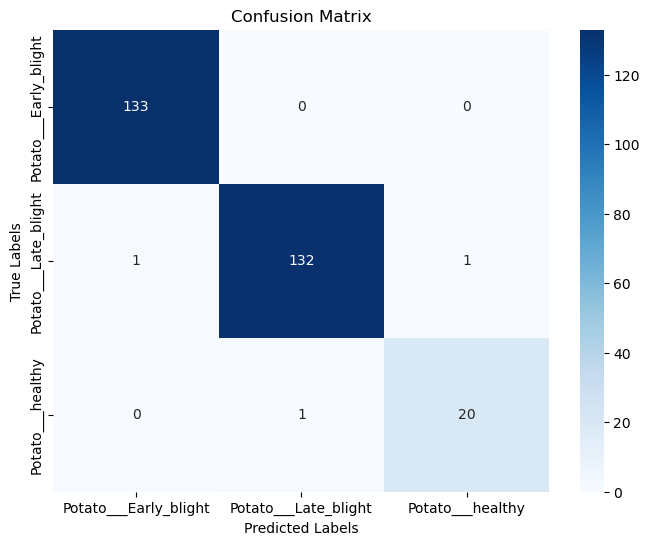

In [62]:
# Get the class names from the dataset
class_names = dataset.class_names

# Calculate the confusion matrix
confusion = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [63]:
from sklearn.metrics import confusion_matrix, classification_report
classification_rep = classification_report(y_true, y_pred, target_names=class_names)

# Print the classification report
print("Classification Report:\n", classification_rep)

Classification Report:
                        precision    recall  f1-score   support

Potato___Early_blight       0.99      1.00      1.00       133
 Potato___Late_blight       0.99      0.99      0.99       134
     Potato___healthy       0.95      0.95      0.95        21

             accuracy                           0.99       288
            macro avg       0.98      0.98      0.98       288
         weighted avg       0.99      0.99      0.99       288

